In [2]:
#Conection with GoogleDrive
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


#CBIS DDSM Database





In [3]:
!cp "/content/gdrive/My Drive/ITBA 2020/Redes Neuronales/Final/CBIS_DDSM.zip" .
!unzip -qq CBIS_DDSM.zip
!rm CBIS_DDSM.zip
cbis_path = 'CBIS_DDSM'

# Librarys

In [4]:
%tensorflow_version 1.x
import os
import numpy as np
import cv2
import statistics
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from tensorflow.keras.regularizers import l2
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop, SGD, Adam, Adadelta, Adagrad, Adamax, Nadam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

TensorFlow 1.x selected.


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#Functions

In [5]:
def load_training():
    """
    Load the training set (excluding baseline patches)
    """
    images = np.load(os.path.join(cbis_path, 'numpy data', 'train_tensor.npy'))[1::2]
    labels = np.load(os.path.join(cbis_path, 'numpy data', 'train_labels.npy'))[1::2]
    return images, labels


def load_testing():
    """
    Load the test set (abnormalities patches and labels, no baseline)
    """
    images = np.load(os.path.join(cbis_path, 'numpy data', 'public_test_tensor.npy'))[1::2]
    labels = np.load(os.path.join(cbis_path, 'numpy data', 'public_test_labels.npy'))[1::2]
    return images, labels


def remap_label(l):
    """
    Remap the labels to 0-->mass 1-->calcification
    """
    if l == 1 or l == 2:
        return 0
    elif l == 3 or l == 4:
        return 1
    else:
        print("[WARN] Unrecognized label (%d)" % l)
        return None

#Load data and process

In [6]:
# Load training and test images (abnormalities only, no baseline)
train_images, train_labels= load_training()
test_images, test_labels= load_testing()

# Number of images
n_train_img = train_images.shape[0]
n_test_img = test_images.shape[0]
print("Train size: %d \t Test size: %d" % (n_train_img, n_test_img))

# Compute width and height of images
img_w = train_images.shape[1]
img_h = train_images.shape[2]
print("Image size: %dx%d" % (img_w, img_h))

# Remap labels
train_labels = np.array([remap_label(l) for l in train_labels])
test_labels = np.array([remap_label(l) for l in test_labels])

# Create a new dimension for color in the images arrays
train_images = train_images.reshape((n_train_img, img_w, img_h, 1))
test_images = test_images.reshape((n_test_img, img_w, img_h, 1))

# Convert from 16-bit (0-65535) to float (0-1)
train_images = train_images.astype('uint16') / 65535
test_images = test_images.astype('uint16') / 65535

# Shuffle the training set (originally sorted by label)
perm = np.random.permutation(n_train_img)
train_images = train_images[perm]
train_labels = train_labels[perm]

# Create a generator for training images
train_datagen = ImageDataGenerator(
    validation_split=0.2
)

# Fit the generator with some images
train_datagen.fit(train_images)

# Split train images into actual training and validation
train_generator = train_datagen.flow(train_images, train_labels, batch_size=32, subset='training')
validation_generator = train_datagen.flow(train_images, train_labels, batch_size=32, subset='validation')


Train size: 2676 	 Test size: 336
Image size: 150x150


#Check images

15 15


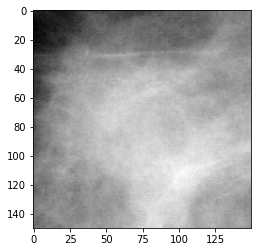

Label: 0


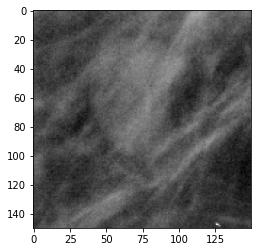

Label: 0


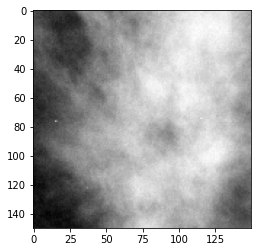

Label: 0


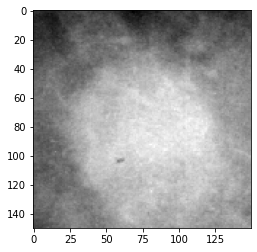

Label: 0


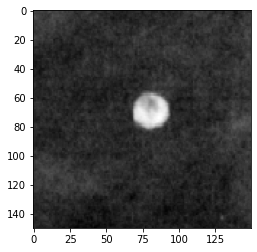

Label: 1


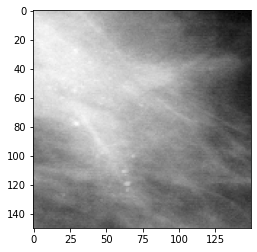

Label: 1


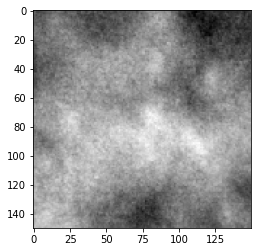

Label: 1


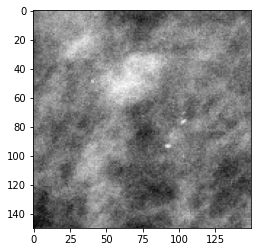

Label: 1


In [ ]:
# Check images from the dataset and its label
mass_index=[]
calc_index=[]
for i in range(30):
  if (int(train_labels[i]) == 0):
    mass_index.append(i)
  if (int(train_labels[i]) == 1):
    calc_index.append(i)
print(len(mass_index), len(calc_index))

plt.imshow(train_images[mass_index[0]][:,:,0], cmap='gray')
plt.show()
print("Label: " + str(train_labels[mass_index[0]]))
plt.imshow(train_images[mass_index[1]][:,:,0], cmap='gray')
plt.show()
print("Label: " + str(train_labels[mass_index[1]]))
plt.imshow(train_images[mass_index[2]][:,:,0], cmap='gray')
plt.show()
print("Label: " + str(train_labels[mass_index[2]]))
plt.imshow(train_images[mass_index[3]][:,:,0], cmap='gray')
plt.show()
print("Label: " + str(train_labels[mass_index[3]]))


plt.imshow(train_images[calc_index[0]][:,:,0], cmap='gray')
plt.show()
print("Label: " + str(train_labels[calc_index[0]]))
plt.imshow(train_images[calc_index[1]][:,:,0], cmap='gray')
plt.show()
print("Label: " + str(train_labels[calc_index[1]]))
plt.imshow(train_images[calc_index[2]][:,:,0], cmap='gray')
plt.show()
print("Label: " + str(train_labels[calc_index[2]]))
plt.imshow(train_images[calc_index[3]][:,:,0], cmap='gray')
plt.show()
print("Label: " + str(train_labels[calc_index[3]]))


#Modelo 0

In [ ]:
#model 0
model_0 = models.Sequential()
model_0.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
model_0.add(layers.MaxPooling2D((2, 2)))
model_0.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_0.add(layers.MaxPooling2D((2, 2)))
model_0.add(layers.Flatten())
model_0.add(layers.Dense(16, activation='relu'))
model_0.add(layers.Dense(1, activation='sigmoid'))

model_0.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 148, 148, 32)      320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 82944)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                1327120   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

#Compile, Train, Save

In [ ]:
# Callback for checkpointing
checkpoint = ModelCheckpoint('model_0_2cl_best.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

# Compile the model
model_0.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

# Train
history_0 = model_0.fit_generator(
        train_generator,
        steps_per_epoch=int(0.8*n_train_img) // 32,
        epochs=100,
        validation_data=validation_generator,
        callbacks=[checkpoint],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

# Save
models.save_model(model_0, 'model_0_2cl_end.h5')
!cp model* "/content/gdrive/My Drive/ITBA 2020/Redes Neuronales/Final/models/"

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/100
17/66 [======>.......................] - ETA: 10s - loss: 1.0619 - acc: 0.5551
Epoch 00001: val_loss improved from inf to 1.06191, saving model to model_0_2cl_best.h5
66/66 [==============================] - 57s 868ms/step - loss: 0.7381 - acc: 0.5434 - val_loss: 1.0619 - val_acc: 0.5551
Epoch 2/100
17/66 [======>.......................] - ETA: 10s - loss: 0.6897 - acc: 0.4935
Epoch 00002: val_loss improved from 1.06191 to 0.68972, saving model to model_0_2cl_best.h5
66/66 [==============================] - 56s 852ms/step - loss: 0.7040 - acc: 0.5334 - val_loss: 0.6897 - val_acc: 0.4935
Epoch 3/100
17/66 [======>.......................] - ETA: 10s - loss: 0.6783 - acc: 0.5813
Epoch 00003: val_loss improved from 0.68972 to 0.67825, saving model to model_0_2cl_best.h5
66/66 [==============================] - 56s 853ms/step - loss: 0.6856 - acc: 0.5434 - val_loss: 0.6783 - val_acc: 0.

# Results 0

In [ ]:
# History of accuracy and loss
tra_loss_0 = history_0.history['loss']
tra_acc_0 = history_0.history['acc']
val_loss_0 = history_0.history['val_loss']
val_acc_0 = history_0.history['val_acc']

# Total number of epochs training
epochs_0 = range(1, len(tra_acc_0)+1)
end_epoch_0 = len(tra_acc_0)

# Epoch when reached the validation loss minimum
opt_epoch_0 = val_loss_0.index(min(val_loss_0)) + 1

# Loss and accuracy on the validation set
end_val_loss_0 = val_loss_0[-1]
end_val_acc_0 = val_acc_0[-1]
opt_val_loss_0 = val_loss_0[opt_epoch_0-1]
opt_val_acc_0 = val_acc_0[opt_epoch_0-1]

# Loss and accuracy on the test set
opt_model_0 = models.load_model('model_0_2cl_best.h5')
test_loss_0, test_acc_0 = model_0.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_0, opt_test_acc_0 = opt_model_0.evaluate(test_images, test_labels, verbose=False)
opt_pred_0 = opt_model_0.predict([test_images, test_labels])
pred_classes_0 = np.rint(opt_pred_0)

print("Model 0\n")

print("Epoch [end]: %d" % end_epoch_0)
print("Epoch [opt]: %d" % opt_epoch_0)
print("Valid accuracy [end]: %.4f" % end_val_acc_0)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_0)
print("Test accuracy [end]:  %.4f" % test_acc_0)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_0)
print("Valid loss [end]: %.4f" % end_val_loss_0)
print("Valid loss [opt]: %.4f" % opt_val_loss_0)
print("Test loss [end]:  %.4f" % test_loss_0)
print("Test loss [opt]:  %.4f" % opt_test_loss_0)

print(classification_report(test_labels, pred_classes_0, digits=4))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model 0

Epoch [end]: 100
Epoch [opt]: 7
Valid accuracy [end]: 0.8243
Valid accuracy [opt]: 0.7738
Test accuracy [end]:  0.8095
Test accuracy [opt]:  0.7292
Valid loss [end]: 1.0847
Valid loss [opt]: 0.4764
Test loss [end]:  1.6015
Test loss [opt]:  0.5638
              precision    recall  f1-score   support

           0     0.7619    0.7151    0.7378       179
           1     0.6964    0.7452    0.7200       157

    accuracy                         0.7292       336
   macro avg     0.7292    0.7302    0.7289       336
weighted avg     0.7313    0.7292    0.7295       336



#Accuracy, Loss 0

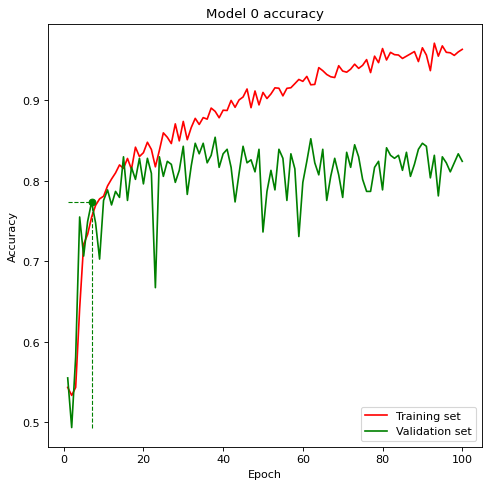

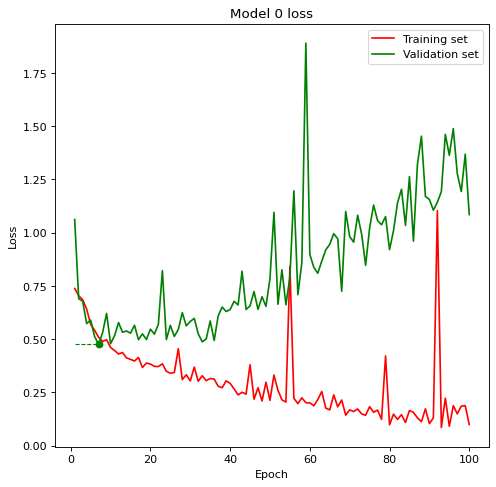

In [ ]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model 0 accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_0, tra_acc_0, 'r', label='Training set')
plt.plot(epochs_0, val_acc_0, 'g', label='Validation set')
plt.plot(opt_epoch_0, val_acc_0[opt_epoch_0-1], 'go')
plt.vlines(opt_epoch_0, min(val_acc_0), opt_val_acc_0, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_0, 1, opt_epoch_0, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model 0 loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_0, tra_loss_0, 'r', label='Training set')
plt.plot(epochs_0, val_loss_0, 'g', label='Validation set')
plt.plot(opt_epoch_0, val_loss_0[opt_epoch_0-1], 'go')
plt.vlines(opt_epoch_0, min(val_loss_0), opt_val_loss_0, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_0, 1, opt_epoch_0, linestyle="dashed", color='g', linewidth=1)
plt.legend();

#Model 1
Add Dropout layer to reduce overfitting

In [ ]:
model_1 = models.Sequential()
model_1.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
model_1.add(layers.MaxPooling2D((2, 2)))
model_1.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_1.add(layers.MaxPooling2D((2, 2)))
model_1.add(layers.Flatten())
model_1.add(layers.Dense(16, activation='relu'))
model_1.add(layers.Dropout(0.5))
model_1.add(layers.Dense(1, activation='sigmoid'))

model_1.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 148, 148, 32)      320       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 82944)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 16)                1327120   
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)               

#Compile, Train, Save

In [ ]:
# Callback for checkpointing
checkpoint = ModelCheckpoint('model_1_2cl_best.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

# Compile the model
model_1.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

# Train
history_1 = model_1.fit_generator(
        train_generator,
        steps_per_epoch=int(0.8*n_train_img) // 32,
        epochs=100,
        validation_data=validation_generator,
        callbacks=[checkpoint],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

# Save
models.save_model(model_1, 'model_1_2cl_end.h5')
!cp model* "/content/gdrive/My Drive/ITBA 2020/Redes Neuronales/Final/models/models/"

Epoch 1/100
17/66 [======>.......................] - ETA: 11s - loss: 0.6857 - acc: 0.5551
Epoch 00001: val_loss improved from inf to 0.68570, saving model to model_1_2cl_best.h5
66/66 [==============================] - 58s 872ms/step - loss: 0.7325 - acc: 0.5377 - val_loss: 0.6857 - val_acc: 0.5551
Epoch 2/100
17/66 [======>.......................] - ETA: 11s - loss: 0.6971 - acc: 0.5551
Epoch 00002: val_loss did not improve from 0.68570
66/66 [==============================] - 57s 858ms/step - loss: 0.6914 - acc: 0.5235 - val_loss: 0.6971 - val_acc: 0.5551
Epoch 3/100
17/66 [======>.......................] - ETA: 11s - loss: 0.6871 - acc: 0.5533
Epoch 00003: val_loss did not improve from 0.68570
66/66 [==============================] - 57s 859ms/step - loss: 0.6951 - acc: 0.5320 - val_loss: 0.6871 - val_acc: 0.5533
Epoch 4/100
17/66 [======>.......................] - ETA: 11s - loss: 0.6871 - acc: 0.5551
Epoch 00004: val_loss did not improve from 0.68570
66/66 [======================

# Results 1

In [ ]:
# History of accuracy and loss
tra_loss_1 = history_1.history['loss']
tra_acc_1 = history_1.history['acc']
val_loss_1 = history_1.history['val_loss']
val_acc_1 = history_1.history['val_acc']

# Total number of epochs training
epochs_1 = range(1, len(tra_acc_1)+1)
end_epoch_1 = len(tra_acc_1)

# Epoch when reached the validation loss minimum
opt_epoch_1 = val_loss_1.index(min(val_loss_1)) + 1

# Loss and accuracy on the validation set
end_val_loss_1 = val_loss_1[-1]
end_val_acc_1 = val_acc_1[-1]
opt_val_loss_1 = val_loss_1[opt_epoch_1-1]
opt_val_acc_1 = val_acc_1[opt_epoch_1-1]

# Loss and accuracy on the test set
opt_model_1 = models.load_model('model_1_2cl_best.h5')
test_loss_1, test_acc_1 = model_1.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_1, opt_test_acc_1 = opt_model_1.evaluate(test_images, test_labels, verbose=False)
opt_pred_1 = opt_model_1.predict([test_images, test_labels])
pred_classes_1 = np.rint(opt_pred_1)

print("Model 1\n")

print("Epoch [end]: %d" % end_epoch_1)
print("Epoch [opt]: %d" % opt_epoch_1)
print("Valid accuracy [end]: %.4f" % end_val_acc_1)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_1)
print("Test accuracy [end]:  %.4f" % test_acc_1)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_1)
print("Valid loss [end]: %.4f" % end_val_loss_1)
print("Valid loss [opt]: %.4f" % opt_val_loss_1)
print("Test loss [end]:  %.4f" % test_loss_1)
print("Test loss [opt]:  %.4f" % opt_test_loss_1)

print(classification_report(test_labels, pred_classes_1, digits=4))

Model 1

Epoch [end]: 100
Epoch [opt]: 58
Valid accuracy [end]: 0.8037
Valid accuracy [opt]: 0.8411
Test accuracy [end]:  0.7649
Test accuracy [opt]:  0.7827
Valid loss [end]: 0.5982
Valid loss [opt]: 0.4094
Test loss [end]:  0.8319
Test loss [opt]:  0.5626
              precision    recall  f1-score   support

           0     0.8011    0.7877    0.7944       179
           1     0.7625    0.7771    0.7697       157

    accuracy                         0.7827       336
   macro avg     0.7818    0.7824    0.7820       336
weighted avg     0.7831    0.7827    0.7828       336



#Accuracy, Loss 1

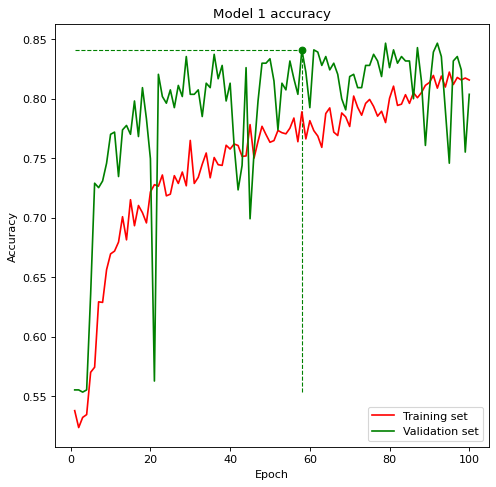

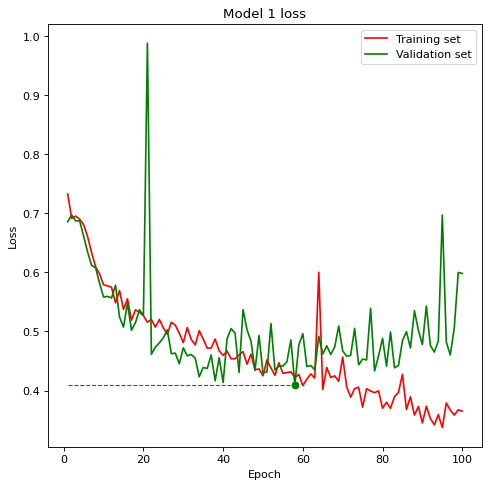

In [ ]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model 1 accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_1, tra_acc_1, 'r', label='Training set')
plt.plot(epochs_1, val_acc_1, 'g', label='Validation set')
plt.plot(opt_epoch_1, val_acc_1[opt_epoch_1-1], 'go')
plt.vlines(opt_epoch_1, min(val_acc_1), opt_val_acc_1, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_1, 1, opt_epoch_1, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model 1 loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_1, tra_loss_1, 'r', label='Training set')
plt.plot(epochs_1, val_loss_1, 'g', label='Validation set')
plt.plot(opt_epoch_1, val_loss_1[opt_epoch_1-1], 'go')
plt.vlines(opt_epoch_1, min(val_loss_1), opt_val_loss_1, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_1, 1, opt_epoch_1, linestyle="dashed", color='g', linewidth=1)
plt.legend();

#Model 2
Data augmentation (regularization) to reduce overfitting.

In [ ]:
# Create a generator for training images
train_datagen = ImageDataGenerator(
    validation_split=0.2,
    rotation_range=180,
    shear_range=10,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='reflect'
)

# Fit the generator with some images
train_datagen.fit(train_images)

# Split train images into actual training and validation
train_generator = train_datagen.flow(train_images, train_labels, batch_size=32, subset='training')
validation_generator = train_datagen.flow(train_images, train_labels, batch_size=32, subset='validation')

In [ ]:
model_2 = models.Sequential()
model_2.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
model_2.add(layers.MaxPooling2D((2, 2)))
model_2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_2.add(layers.MaxPooling2D((2, 2)))
model_2.add(layers.Flatten())
model_2.add(layers.Dense(16, activation='relu'))
model_2.add(layers.Dropout(0.5))
model_2.add(layers.Dense(1, activation='sigmoid'))

model_2.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 148, 148, 32)      320       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 82944)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 16)                1327120   
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)               

#Compile, Train, Save

In [ ]:
# Callback for checkpointing
checkpoint = ModelCheckpoint('model_2_2cl_best.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

# Compile the model
model_2.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

# Train
history_2 = model_2.fit_generator(
        train_generator,
        steps_per_epoch=int(0.8*n_train_img) // 32,
        epochs=100,
        validation_data=validation_generator,
        callbacks=[checkpoint],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

# Save
models.save_model(model_2, 'model_2_2cl_end.h5')
!cp model* "/content/gdrive/My Drive/ITBA 2020/Redes Neuronales/Final/models/"

Epoch 1/100
17/66 [======>.......................] - ETA: 13s - loss: 0.6863 - acc: 0.5551
Epoch 00001: val_loss improved from inf to 0.68633, saving model to model_2_2cl_best.h5
66/66 [==============================] - 62s 932ms/step - loss: 0.7163 - acc: 0.5301 - val_loss: 0.6863 - val_acc: 0.5551
Epoch 2/100
17/66 [======>.......................] - ETA: 13s - loss: 0.6871 - acc: 0.5551
Epoch 00002: val_loss did not improve from 0.68633
66/66 [==============================] - 60s 914ms/step - loss: 0.7020 - acc: 0.5344 - val_loss: 0.6871 - val_acc: 0.5551
Epoch 3/100
17/66 [======>.......................] - ETA: 13s - loss: 0.6930 - acc: 0.5551
Epoch 00003: val_loss did not improve from 0.68633
66/66 [==============================] - 60s 908ms/step - loss: 0.6929 - acc: 0.5317 - val_loss: 0.6930 - val_acc: 0.5551
Epoch 4/100
17/66 [======>.......................] - ETA: 13s - loss: 0.6910 - acc: 0.5551
Epoch 00004: val_loss did not improve from 0.68633
66/66 [======================

#Result 2

In [ ]:
# History of accuracy and loss
tra_loss_2 = history_2.history['loss']
tra_acc_2 = history_2.history['acc']
val_loss_2 = history_2.history['val_loss']
val_acc_2 = history_2.history['val_acc']

# Total number of epochs training
epochs_2 = range(1, len(tra_acc_2)+1)
end_epoch_2 = len(tra_acc_2)

# Epoch when reached the validation loss minimum
opt_epoch_2 = val_loss_2.index(min(val_loss_2)) + 1

# Loss and accuracy on the validation set
end_val_loss_2 = val_loss_2[-1]
end_val_acc_2 = val_acc_2[-1]
opt_val_loss_2 = val_loss_2[opt_epoch_2-1]
opt_val_acc_2 = val_acc_2[opt_epoch_2-1]

# Loss and accuracy on the test set
opt_model_2 = models.load_model('model_2_2cl_best.h5')
test_loss_2, test_acc_2 = model_2.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_2, opt_test_acc_2 = opt_model_2.evaluate(test_images, test_labels, verbose=False)
opt_pred_2 = opt_model_2.predict([test_images, test_labels])
pred_classes_2 = np.rint(opt_pred_2)

print("Model 2\n")

print("Epoch [end]: %d" % end_epoch_2)
print("Epoch [opt]: %d" % opt_epoch_2)
print("Valid accuracy [end]: %.4f" % end_val_acc_2)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_2)
print("Test accuracy [end]:  %.4f" % test_acc_2)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_2)
print("Valid loss [end]: %.4f" % end_val_loss_2)
print("Valid loss [opt]: %.4f" % opt_val_loss_2)
print("Test loss [end]:  %.4f" % test_loss_2)
print("Test loss [opt]:  %.4f" % opt_test_loss_2)

print(classification_report(test_labels, pred_classes_2, digits=4))

Model 2

Epoch [end]: 100
Epoch [opt]: 92
Valid accuracy [end]: 0.7925
Valid accuracy [opt]: 0.8224
Test accuracy [end]:  0.8006
Test accuracy [opt]:  0.8155
Valid loss [end]: 0.4579
Valid loss [opt]: 0.4121
Test loss [end]:  0.5026
Test loss [opt]:  0.4796
              precision    recall  f1-score   support

           0     0.8000    0.8715    0.8342       179
           1     0.8369    0.7516    0.7919       157

    accuracy                         0.8155       336
   macro avg     0.8184    0.8116    0.8131       336
weighted avg     0.8172    0.8155    0.8145       336



#Accuracy, Loss 2

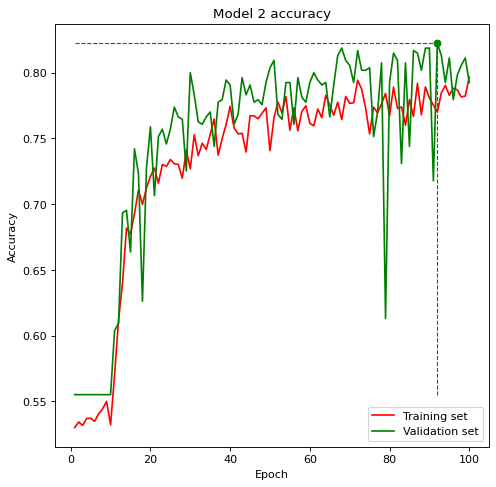

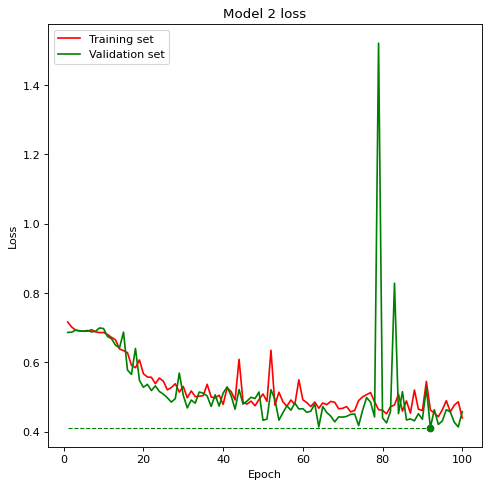

In [ ]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model 2 accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_2, tra_acc_2, 'r', label='Training set')
plt.plot(epochs_2, val_acc_2, 'g', label='Validation set')
plt.plot(opt_epoch_2, val_acc_2[opt_epoch_2-1], 'go')
plt.vlines(opt_epoch_2, min(val_acc_2), opt_val_acc_2, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_2, 1, opt_epoch_2, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model 2 loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_2, tra_loss_2, 'r', label='Training set')
plt.plot(epochs_2, val_loss_2, 'g', label='Validation set')
plt.plot(opt_epoch_2, val_loss_2[opt_epoch_2-1], 'go')
plt.vlines(opt_epoch_2, min(val_loss_2), opt_val_loss_2, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_2, 1, opt_epoch_2, linestyle="dashed", color='g', linewidth=1)
plt.legend();

#Model 3
Add learning rate decay to reduce loss and accuracy fluctuations

In [ ]:
model_5 = models.Sequential()
model_5.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
model_5.add(layers.MaxPooling2D((2, 2)))
model_5.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_5.add(layers.MaxPooling2D((2, 2)))
model_5.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_5.add(layers.MaxPooling2D((2, 2)))
model_5.add(layers.Flatten())
model_5.add(layers.Dense(48, activation='relu'))
model_5.add(layers.Dropout(0.5))
model_5.add(layers.Dense(1, activation='sigmoid'))

model_5.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 148, 148, 32)      320       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 36992)            

In [ ]:
# Increase batch size
train_generator = train_datagen.flow(train_images, train_labels, batch_size=128, subset='training')
validation_generator = train_datagen.flow(train_images, train_labels, batch_size=128, subset='validation')

#Compile, Train, Save 3

In [ ]:
# Early stopping (stop training after the validation loss reaches the minimum)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=80, verbose=1)

# Callback for checkpointing
checkpoint = ModelCheckpoint('model_5_2cl_best.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

# Compile the model (note the decay!)
model_5.compile(optimizer=RMSprop(learning_rate=0.001, decay=1e-3), loss='binary_crossentropy', metrics=['accuracy'])

# Train
history_5 = model_5.fit_generator(
        train_generator,
        steps_per_epoch=int(0.8*n_train_img) // 128,
        epochs=500,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

# Save
models.save_model(model_5, 'model_5_2cl_end.h5')
!cp model* "/content/gdrive/My Drive/ITBA 2020/Redes Neuronales/Final/models/"


Epoch 1/500
17/16 [===============================] - 6s 340ms/step - loss: 0.7141 - acc: 0.5439

Epoch 00001: val_loss improved from inf to 0.71091, saving model to model_5_2cl_best.h5
16/16 [==============================] - 25s 2s/step - loss: 0.8408 - acc: 0.5488 - val_loss: 0.7109 - val_acc: 0.5439
Epoch 2/500
17/16 [===============================] - 5s 317ms/step - loss: 0.6886 - acc: 0.5439

Epoch 00002: val_loss improved from 0.71091 to 0.68961, saving model to model_5_2cl_best.h5
16/16 [==============================] - 24s 1s/step - loss: 0.6928 - acc: 0.5234 - val_loss: 0.6896 - val_acc: 0.5439
Epoch 3/500
17/16 [===============================] - 5s 318ms/step - loss: 0.6895 - acc: 0.5439

Epoch 00003: val_loss improved from 0.68961 to 0.68924, saving model to model_5_2cl_best.h5
16/16 [==============================] - 24s 2s/step - loss: 0.6989 - acc: 0.4922 - val_loss: 0.6892 - val_acc: 0.5439
Epoch 4/500
17/16 [===============================] - 6s 326ms/step - loss: 0

# Results 3

In [ ]:
# History of accuracy and loss
tra_loss_5 = history_5.history['loss']
tra_acc_5 = history_5.history['acc']
val_loss_5 = history_5.history['val_loss']
val_acc_5 = history_5.history['val_acc']

# Total number of epochs training
epochs_5 = range(1, len(tra_acc_5)+1)
end_epoch_5 = len(tra_acc_5)

# Epoch when reached the validation loss minimum
opt_epoch_5 = val_loss_5.index(min(val_loss_5)) + 1

# Loss and accuracy on the validation set
end_val_loss_5 = val_loss_5[-1]
end_val_acc_5 = val_acc_5[-1]
opt_val_loss_5 = val_loss_5[opt_epoch_5-1]
opt_val_acc_5 = val_acc_5[opt_epoch_5-1]

# Loss and accuracy on the test set
opt_model_5 = models.load_model('model_5_2cl_best.h5')
test_loss_5, test_acc_5 = model_5.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_5, opt_test_acc_5 = opt_model_5.evaluate(test_images, test_labels, verbose=False)
opt_pred_5 = opt_model_5.predict([test_images, test_labels])
pred_classes_5 = np.rint(opt_pred_5)

print("Model 5\n")

print("Epoch [end]: %d" % end_epoch_5)
print("Epoch [opt]: %d" % opt_epoch_5)
print("Valid accuracy [end]: %.4f" % end_val_acc_5)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_5)
print("Test accuracy [end]:  %.4f" % test_acc_5)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_5)
print("Valid loss [end]: %.4f" % end_val_loss_5)
print("Valid loss [opt]: %.4f" % opt_val_loss_5)
print("Test loss [end]:  %.4f" % test_loss_5)
print("Test loss [opt]:  %.4f" % opt_test_loss_5)

print(classification_report(test_labels, pred_classes_5, digits=4))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model 5

Epoch [end]: 314
Epoch [opt]: 234
Valid accuracy [end]: 0.8729
Valid accuracy [opt]: 0.8748
Test accuracy [end]:  0.8423
Test accuracy [opt]:  0.8304
Valid loss [end]: 0.3345
Valid loss [opt]: 0.2835
Test loss [end]:  0.5533
Test loss [opt]:  0.4471
              precision    recall  f1-score   support

           0     0.8144    0.8827    0.8472       179
           1     0.8521    0.7707    0.8094       157

    accuracy                         0.8304       336
   macro avg     0.8333    0.8267    0.8283       336
weighted avg     0.8320    0.8304    0.8295       336



#Accuracy, Loss 3

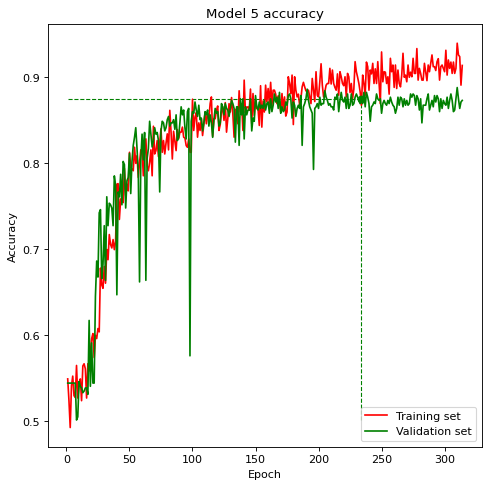

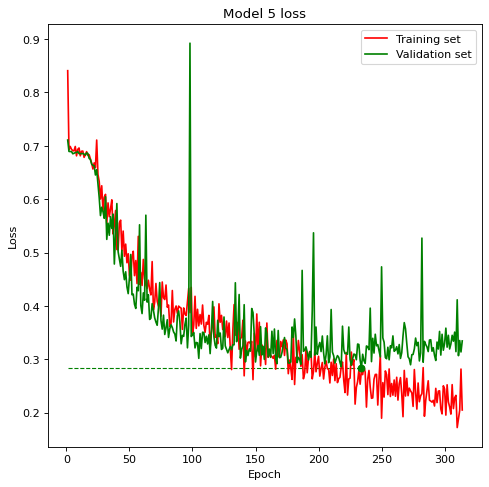

In [ ]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model 5 accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_5, tra_acc_5, 'r', label='Training set')
plt.plot(epochs_5, val_acc_5, 'g', label='Validation set')
plt.plot(opt_epoch_5, val_acc_5[opt_epoch_5-1], 'go')
plt.vlines(opt_epoch_5, min(val_acc_5), opt_val_acc_5, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_5, 1, opt_epoch_5, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model 5 loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_5, tra_loss_5, 'r', label='Training set')
plt.plot(epochs_5, val_loss_5, 'g', label='Validation set')
plt.plot(opt_epoch_5, val_loss_5[opt_epoch_5-1], 'go')
plt.vlines(opt_epoch_5, min(val_loss_5), opt_val_loss_5, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_5, 1, opt_epoch_5, linestyle="dashed", color='g', linewidth=1)
plt.legend();

#Model 4
Model 3 with an extra convolutional block with 256 features

In [ ]:
model_6 = models.Sequential()
model_6.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
model_6.add(layers.MaxPooling2D((2, 2)))
model_6.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_6.add(layers.MaxPooling2D((2, 2)))
model_6.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_6.add(layers.MaxPooling2D((2, 2)))
model_6.add(layers.Conv2D(256, (3, 3), activation='relu'))
model_6.add(layers.MaxPooling2D((2, 2)))
model_6.add(layers.Flatten())
model_6.add(layers.Dense(48, activation='relu'))
model_6.add(layers.Dropout(0.5))
model_6.add(layers.Dense(1, activation='sigmoid'))

model_6.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 148, 148, 32)      320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 15, 15, 256)      

#Compile, Train, Save 4

In [ ]:
# Early stopping (stop training after the validation loss reaches the minimum)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=80, verbose=1)

# Callback for checkpointing
checkpoint = ModelCheckpoint('model_6_2cl_best.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

# Compile the model (note the decay!)
model_6.compile(optimizer=RMSprop(learning_rate=0.001, decay=1e-3), loss='binary_crossentropy', metrics=['accuracy'])

# Train
history_6 = model_6.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 128,
        epochs=500,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

# Save
models.save_model(model_6, 'model_6_2cl_end.h5')
!cp model* "/content/gdrive/My Drive/ITBA 2020/Redes Neuronales/Final/models/"

Epoch 1/500
17/20 [========================>.....] - ETA: 1s - loss: 0.6931 - acc: 0.4785
Epoch 00001: val_loss improved from inf to 0.69312, saving model to model_6_2cl_best.h5
20/20 [==============================] - 37s 2s/step - loss: 0.7406 - acc: 0.4891 - val_loss: 0.6931 - val_acc: 0.4785
Epoch 2/500
17/20 [========================>.....] - ETA: 1s - loss: 0.6912 - acc: 0.5645
Epoch 00002: val_loss improved from 0.69312 to 0.69121, saving model to model_6_2cl_best.h5
20/20 [==============================] - 36s 2s/step - loss: 0.6940 - acc: 0.5109 - val_loss: 0.6912 - val_acc: 0.5645
Epoch 3/500
17/20 [========================>.....] - ETA: 1s - loss: 0.6894 - acc: 0.5645
Epoch 00003: val_loss improved from 0.69121 to 0.68944, saving model to model_6_2cl_best.h5
20/20 [==============================] - 37s 2s/step - loss: 0.7058 - acc: 0.5495 - val_loss: 0.6894 - val_acc: 0.5645
Epoch 4/500
17/20 [========================>.....] - ETA: 1s - loss: 0.6887 - acc: 0.5645
Epoch 00004

#Results 4

In [ ]:
# History of accuracy and loss
tra_loss_6 = history_6.history['loss']
tra_acc_6 = history_6.history['acc']
val_loss_6 = history_6.history['val_loss']
val_acc_6 = history_6.history['val_acc']

# Total number of epochs training
epochs_6 = range(1, len(tra_acc_6)+1)
end_epoch_6 = len(tra_acc_6)

# Epoch when reached the validation loss minimum
opt_epoch_6 = val_loss_6.index(min(val_loss_6)) + 1

# Loss and accuracy on the validation set
end_val_loss_6 = val_loss_6[-1]
end_val_acc_6 = val_acc_6[-1]
opt_val_loss_6 = val_loss_6[opt_epoch_6-1]
opt_val_acc_6 = val_acc_6[opt_epoch_6-1]

# Loss and accuracy on the test set
opt_model_6 = models.load_model('model_6_2cl_best.h5')
test_loss_6, test_acc_6 = model_6.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_6, opt_test_acc_6 = opt_model_6.evaluate(test_images, test_labels, verbose=False)
opt_pred_6 = opt_model_6.predict([test_images, test_labels])
pred_classes_6 = np.rint(opt_pred_6)

print("Model 6\n")

print("Epoch [end]: %d" % end_epoch_6)
print("Epoch [opt]: %d" % opt_epoch_6)
print("Valid accuracy [end]: %.4f" % end_val_acc_6)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_6)
print("Test accuracy [end]:  %.4f" % test_acc_6)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_6)
print("Valid loss [end]: %.4f" % end_val_loss_6)
print("Valid loss [opt]: %.4f" % opt_val_loss_6)
print("Test loss [end]:  %.4f" % test_loss_6)
print("Test loss [opt]:  %.4f" % opt_test_loss_6)

print(classification_report(test_labels, pred_classes_6, digits=4))

Model 6

Epoch [end]: 167
Epoch [opt]: 87
Valid accuracy [end]: 0.8785
Valid accuracy [opt]: 0.8748
Test accuracy [end]:  0.8482
Test accuracy [opt]:  0.8274
Valid loss [end]: 0.4355
Valid loss [opt]: 0.3309
Test loss [end]:  0.4873
Test loss [opt]:  0.3963
              precision    recall  f1-score   support

           0     0.8380    0.8380    0.8380       179
           1     0.8153    0.8153    0.8153       157

    accuracy                         0.8274       336
   macro avg     0.8266    0.8266    0.8266       336
weighted avg     0.8274    0.8274    0.8274       336



#Accuracy, Loss 4

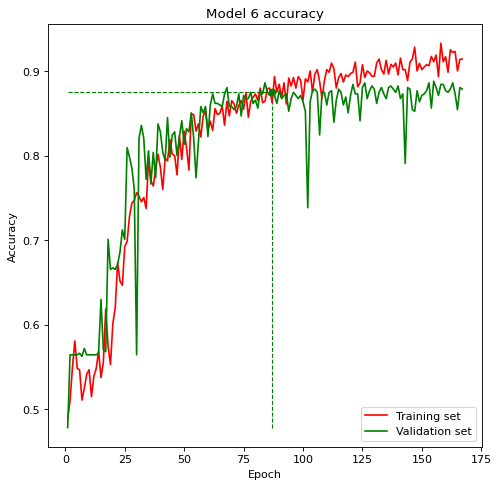

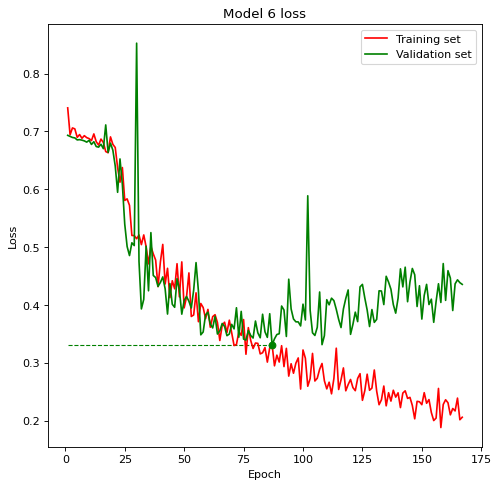

In [ ]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model 6 accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_6, tra_acc_6, 'r', label='Training set')
plt.plot(epochs_6, val_acc_6, 'g', label='Validation set')
plt.plot(opt_epoch_6, val_acc_6[opt_epoch_6-1], 'go')
plt.vlines(opt_epoch_6, min(val_acc_6), opt_val_acc_6, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_6, 1, opt_epoch_6, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model 6 loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_6, tra_loss_6, 'r', label='Training set')
plt.plot(epochs_6, val_loss_6, 'g', label='Validation set')
plt.plot(opt_epoch_6, val_loss_6[opt_epoch_6-1], 'go')
plt.vlines(opt_epoch_6, min(val_loss_6), opt_val_loss_6, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_6, 1, opt_epoch_6, linestyle="dashed", color='g', linewidth=1)
plt.legend();

#Model 5
regularizer: L2

In [ ]:
model_9 = models.Sequential()
model_9.add(layers.Conv2D(32, (3, 3), activation='relu',  input_shape=(150, 150, 1), kernel_regularizer=l2(0.00005)))
model_9.add(layers.MaxPooling2D((2, 2)))
model_9.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.00005)))
model_9.add(layers.MaxPooling2D((2, 2)))
model_9.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.00005)))
model_9.add(layers.MaxPooling2D((2, 2)))
model_9.add(layers.Conv2D(256, (3, 3), activation='relu', kernel_regularizer=l2(0.00005)))
model_9.add(layers.MaxPooling2D((2, 2)))
model_9.add(layers.Flatten())
model_9.add(layers.Dense(48, activation='relu'))
model_9.add(layers.Dropout(0.5))
model_9.add(layers.Dense(1, activation='sigmoid'))

model_9.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_______________________________________

#Compile, Train, Save 5

In [ ]:
# Early stopping (stop training after the validation loss reaches the minimum)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=80, verbose=1)

# Callback for checkpointing
checkpoint = ModelCheckpoint('model_9_2cl_best.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

# Compile the model
model_9.compile(optimizer=RMSprop(learning_rate=0.001, decay=1e-3), loss='binary_crossentropy', metrics=['accuracy'])

# Train
history_9 = model_9.fit_generator(
        train_generator,
        steps_per_epoch=int(0.8*n_train_img) // 128,
        epochs=500,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

# Save
models.save_model(model_9, 'model_9_2cl_end.h5')
!cp model* "/content/gdrive/My Drive/ITBA 2020/Redes Neuronales/Final/models/"

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/500
17/16 [===============================] - 7s 409ms/step - loss: 0.7001 - acc: 0.5645

Epoch 00001: val_loss improved from inf to 0.70005, saving model to model_9_2cl_best.h5
16/16 [==============================] - 32s 2s/step - loss: 0.7203 - acc: 0.4629 - val_loss: 0.7000 - val_acc: 0.5645
Epoch 2/500
17/16 [===============================] - 7s 401ms/step - loss: 0.6987 - acc: 0.5495

Epoch 00002: val_loss improved from 0.70005 to 0.69872, saving model to model_9_2cl_best.h5
16/16 [==============================] - 30s 2s/step - loss: 0.7003 - acc: 0.5108 - val_loss: 0.6987 - val_acc: 0.5495
Epoch 3/500
17/16 [===============================] - 7s 399ms/step - loss: 0.6921 - acc: 0.5645

Epoch 00003: val_loss improved from 0.69872 to 0.69201, saving model to model_9_2cl_best.h5
16/16 [==============================] - 30s 2s/step - loss: 0.6941 - acc: 0.5703 - val_loss: 0.6920 -

#Results 5

In [ ]:
# History of accuracy and loss
tra_loss_9 = history_9.history['loss']
tra_acc_9 = history_9.history['acc']
val_loss_9 = history_9.history['val_loss']
val_acc_9 = history_9.history['val_acc']

# Total number of epochs training
epochs_9 = range(1, len(tra_acc_9)+1)
end_epoch_9 = len(tra_acc_9)

# Epoch when reached the validation loss minimum
opt_epoch_9 = val_loss_9.index(min(val_loss_9)) + 1

# Loss and accuracy on the validation set
end_val_loss_9 = val_loss_9[-1]
end_val_acc_9 = val_acc_9[-1]
opt_val_loss_9 = val_loss_9[opt_epoch_9-1]
opt_val_acc_9 = val_acc_9[opt_epoch_9-1]

# Loss and accuracy on the test set
opt_model_9 = models.load_model('model_9_2cl_best.h5')
test_loss_9, test_acc_9 = model_9.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_9, opt_test_acc_9 = opt_model_9.evaluate(test_images, test_labels, verbose=False)
opt_pred_9 = opt_model_9.predict([test_images, test_labels])
pred_classes_9 = np.rint(opt_pred_9)

print("Model 9\n")

print("Epoch [end]: %d" % end_epoch_9)
print("Epoch [opt]: %d" % opt_epoch_9)
print("Valid accuracy [end]: %.4f" % end_val_acc_9)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_9)
print("Test accuracy [end]:  %.4f" % test_acc_9)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_9)
print("Valid loss [end]: %.4f" % end_val_loss_9)
print("Valid loss [opt]: %.4f" % opt_val_loss_9)
print("Test loss [end]:  %.4f" % test_loss_9)
print("Test loss [opt]:  %.4f" % opt_test_loss_9)

print(classification_report(test_labels, pred_classes_9, digits=4))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model 9

Epoch [end]: 441
Epoch [opt]: 361
Valid accuracy [end]: 0.8860
Valid accuracy [opt]: 0.8879
Test accuracy [end]:  0.8631
Test accuracy [opt]:  0.8423
Valid loss [end]: 0.3058
Valid loss [opt]: 0.2995
Test loss [end]:  0.3488
Test loss [opt]:  0.3609
              precision    recall  f1-score   support

           0     0.8500    0.8547    0.8524       179
           1     0.8333    0.8280    0.8307       157

    accuracy                         0.8423       336
   macro avg     0.8417    0.8414    0.8415       336
weighted avg     0.8422    0.8423    0.8422       336



#Accuracy, Loss 5

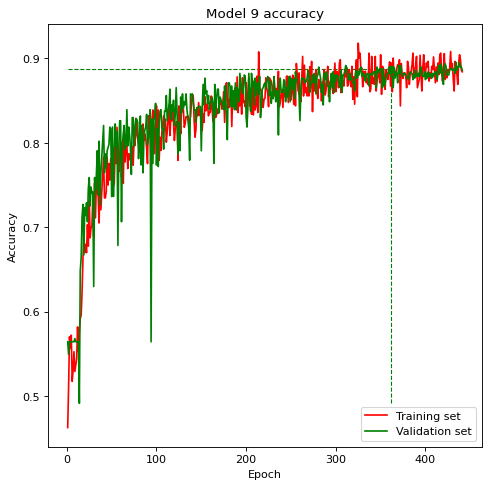

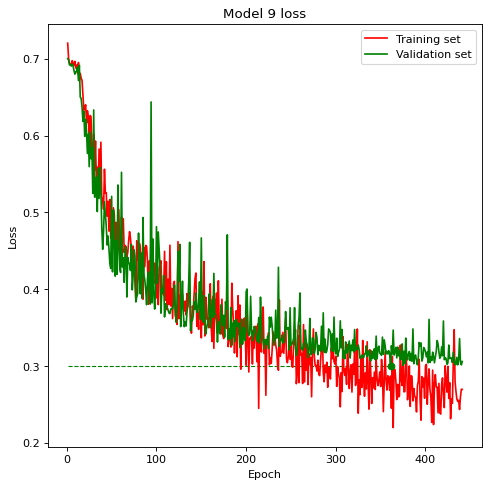

In [ ]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model 9 accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_9, tra_acc_9, 'r', label='Training set')
plt.plot(epochs_9, val_acc_9, 'g', label='Validation set')
plt.plot(opt_epoch_9, val_acc_9[opt_epoch_9-1], 'go')
plt.vlines(opt_epoch_9, min(val_acc_9), opt_val_acc_9, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_9, 1, opt_epoch_9, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model 9 loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_9, tra_loss_9, 'r', label='Training set')
plt.plot(epochs_9, val_loss_9, 'g', label='Validation set')
plt.plot(opt_epoch_9, val_loss_9[opt_epoch_9-1], 'go')
plt.vlines(opt_epoch_9, min(val_loss_9), opt_val_loss_9, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_9, 1, opt_epoch_9, linestyle="dashed", color='g', linewidth=1)
plt.legend();

#ANALYSIS
Model 3,4 and 5

*   Wrong Classification
*   Worse Classification --> >0.8




In [8]:
!cp "/content/gdrive/My Drive/ITBA 2020/Redes Neuronales/Final/models/model_5_2cl_best.h5" .
!cp "/content/gdrive/My Drive/ITBA 2020/Redes Neuronales/Final/models/model_6_2cl_best.h5" .
!cp "/content/gdrive/My Drive/ITBA 2020/Redes Neuronales/Final/models/model_9_2cl_best.h5" .

In [9]:

def get_errors(pred):
    errors = []
    wrong_class = []
    worse_class = []

    for l,p,img in zip(test_labels, pred, test_images):
        err = abs(l-p)
        errors.append(err)
        if err > 0.5:
            wrong_class.append((l,p,img))
        if err > 0.8:
            worse_class.append((l,p,img))

    return errors, wrong_class, worse_class


def show_error_stats(errors, wrong_class, worse_class):

    print("Number of test images: %d" % len(test_labels))
    print("Wrong Classification: %d" % len(wrong_class))
    print("Worse Classification: %d" % len(worse_class))

    sns.distplot(errors, kde=False, rug=True, bins=10, vertical=False, label='samples', axlabel='error').set_title('Absolute error distribution');

    for l,p,img in worse_class:
        plt.figure()
        plt.imshow(img[:,:,0], cmap='gray')
        plt.title('Worst Classification as ' + ('mass' if l==0 else 'calcification') + ' with %.2f confidence' % (100*abs(p-l)))
        plt.axis('off')


opt_model_5 = models.load_model('model_5_2cl_best.h5')
opt_model_6 = models.load_model('model_6_2cl_best.h5')
opt_model_9 = models.load_model('model_9_2cl_best.h5')

pred_5 = opt_model_5.predict(test_images)
pred_6 = opt_model_6.predict(test_images)
pred_9 = opt_model_9.predict(test_images)

errors_5, wrong_class_5, worse_class_5 = get_errors(pred_5)
errors_6, wrong_class_6, worse_class_6 = get_errors(pred_6)
errors_9, wrong_class_9, worse_class_9 = get_errors(pred_9)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


#Model 3 Error

Number of test images: 336
Wrong Classification: 57
Worse Classification: 22


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


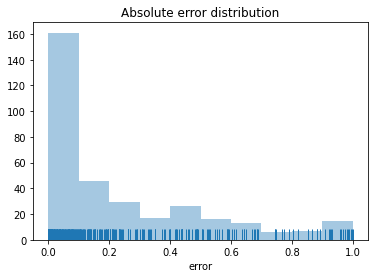

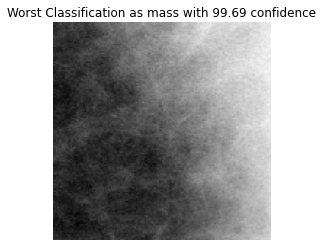

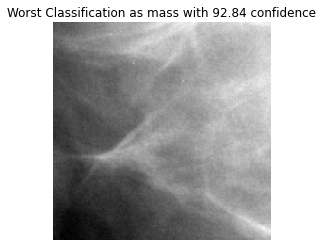

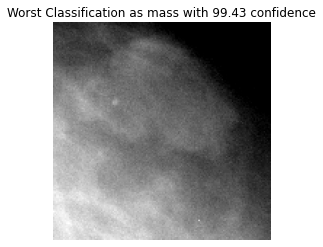

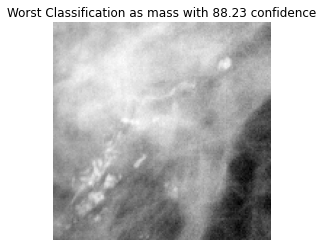

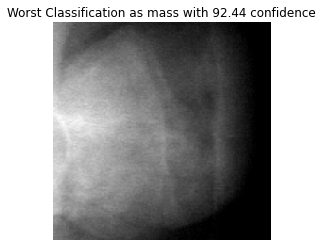

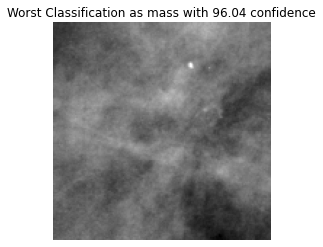

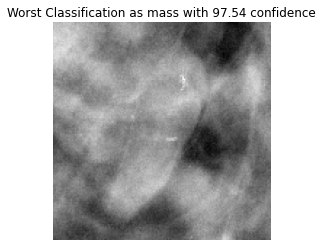

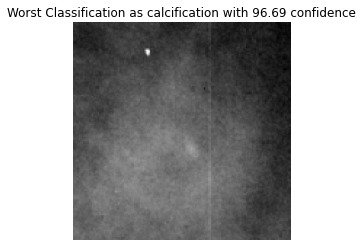

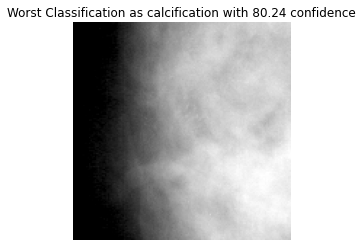

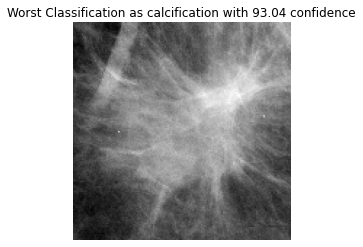

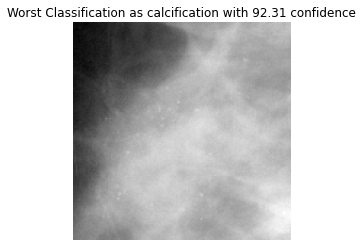

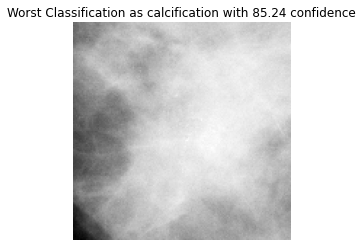

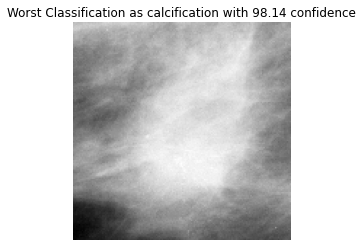

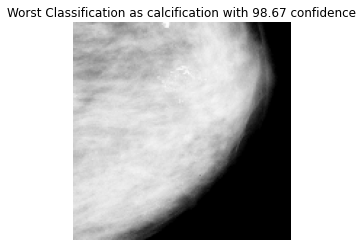

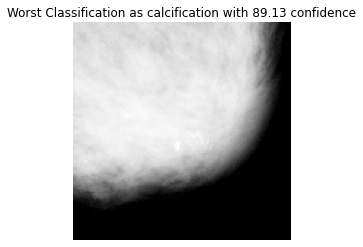

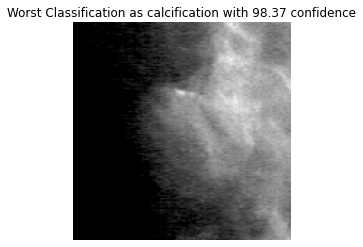

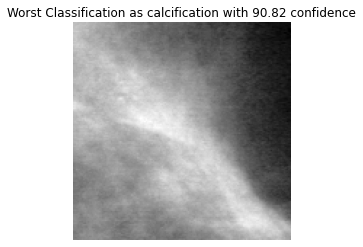

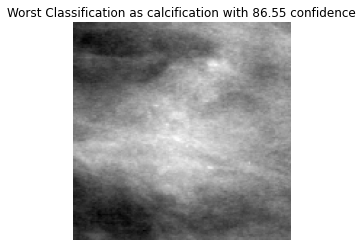

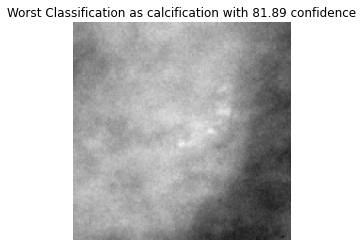

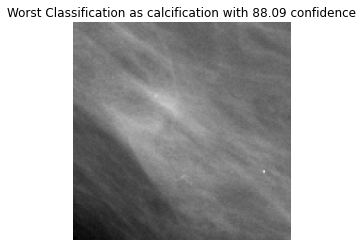

In [ ]:
show_error_stats(errors_5, wrong_class_5, worse_class_5)

#Model 4 Error

Number of test images: 336
Wrong Classification: 58
Worse Classification: 21


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


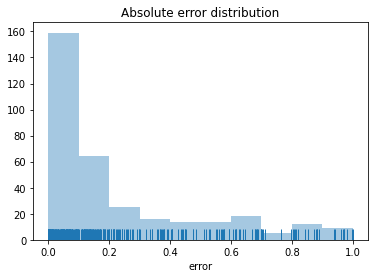

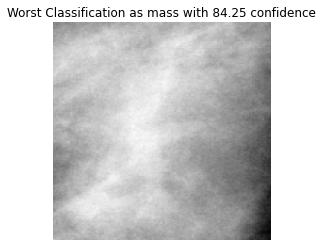

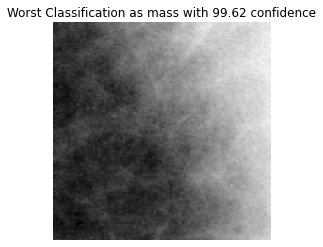

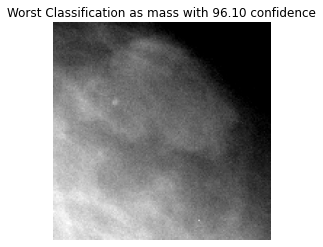

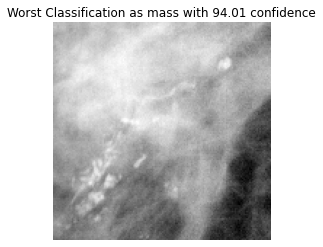

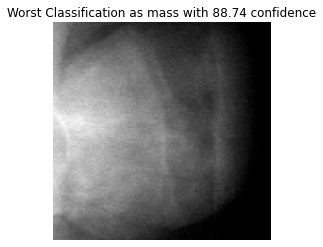

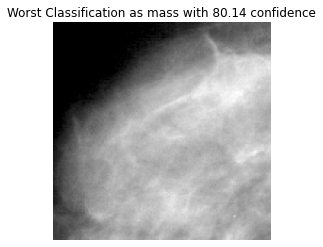

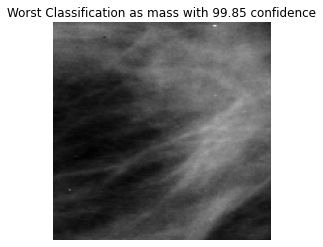

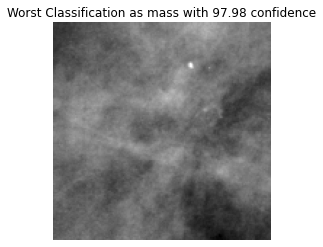

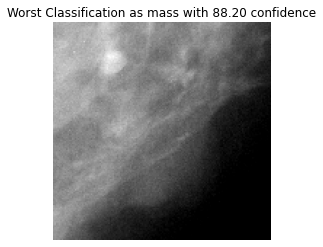

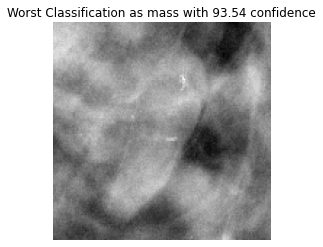

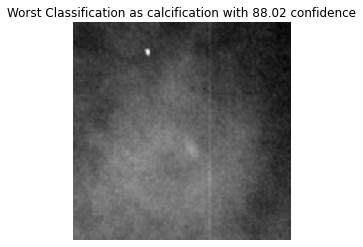

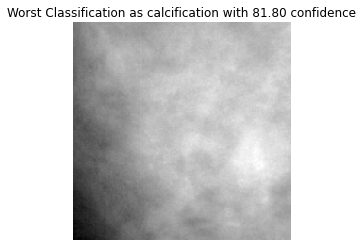

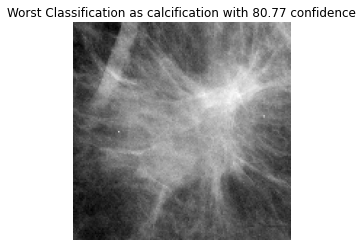

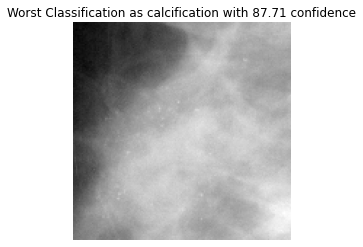

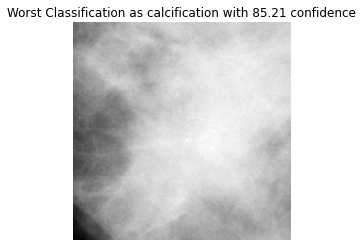

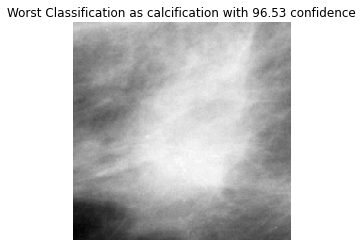

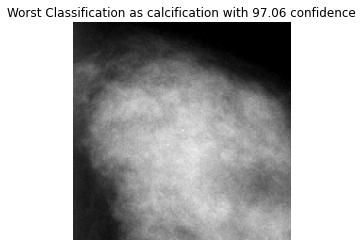

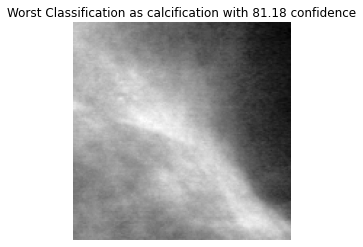

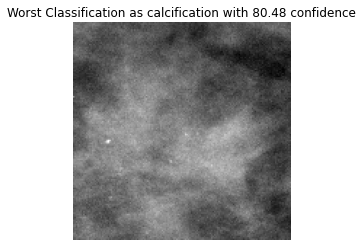

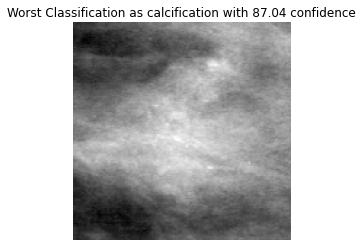

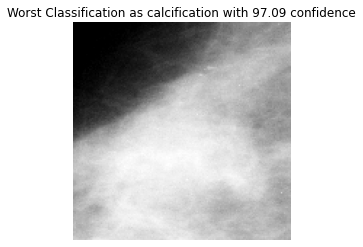

In [ ]:
show_error_stats(errors_6, wrong_class_6, worse_class_6)

#Model 5 Error

Number of test images: 336
Wrong Classification: 53
Worse Classification: 12


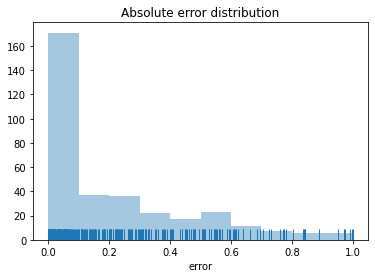

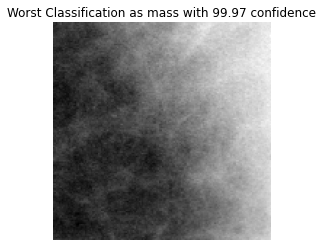

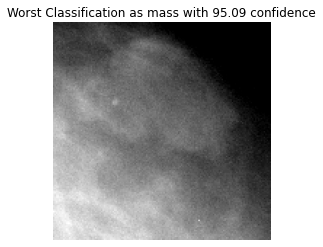

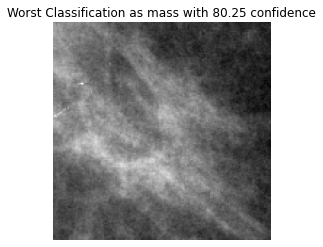

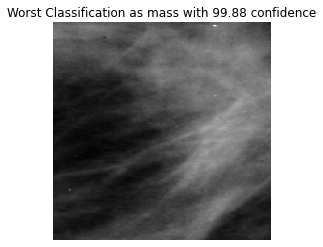

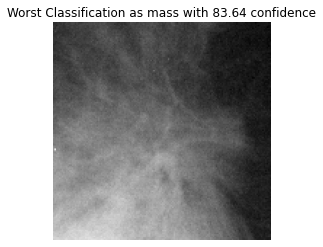

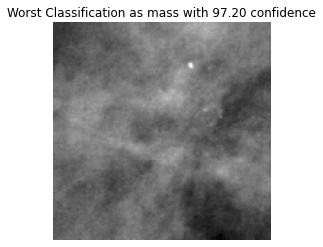

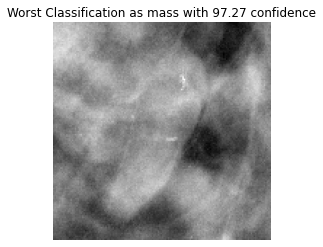

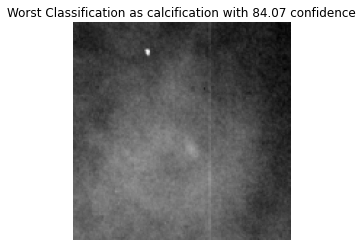

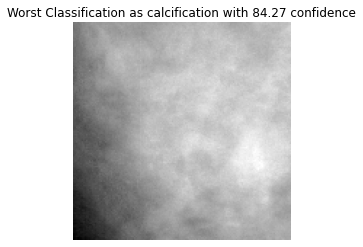

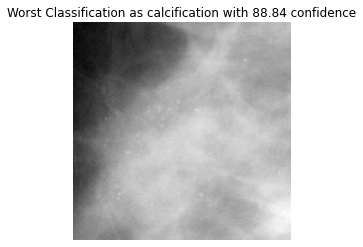

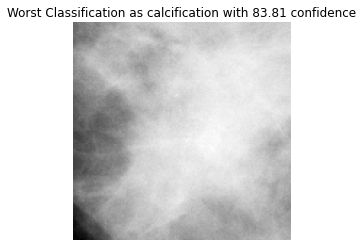

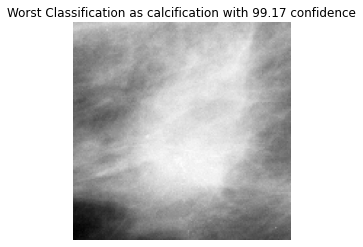

In [ ]:
show_error_stats(errors_9, wrong_class_9, worse_class_9)

In [10]:
correct_5 = np.array([abs(p-l) < 0.5 for p,l in zip(np.squeeze(pred_5), test_labels)])
correct_6 = np.array([abs(p-l) < 0.5 for p,l in zip(np.squeeze(pred_6), test_labels)])
correct_9 = np.array([abs(p-l) < 0.5 for p,l in zip(np.squeeze(pred_9), test_labels)])

wrong_5 = np.logical_not(correct_5)
wrong_6 = np.logical_not(correct_6)
wrong_9 = np.logical_not(correct_9)

hard_wrong_5 = np.array([abs(p-l) > 0.8 for p,l in zip(np.squeeze(pred_5), test_labels)])
hard_wrong_6 = np.array([abs(p-l) > 0.8 for p,l in zip(np.squeeze(pred_6), test_labels)])
hard_wrong_9 = np.array([abs(p-l) > 0.8 for p,l in zip(np.squeeze(pred_9), test_labels)])

differ_5_6 = np.logical_xor(correct_5, correct_6)
differ_5_9 = np.logical_xor(correct_5, correct_9)
differ_6_9 = np.logical_xor(correct_6, correct_9)

wrong_all = np.logical_and(wrong_5, wrong_6, wrong_9)
hard_wrong_all = np.logical_and(hard_wrong_5, hard_wrong_6, hard_wrong_9)

In [ ]:
print("5 and 6 differ for %d samples" % np.sum(differ_5_6))
print("5 and 9 differ for %d samples" % np.sum(differ_5_9))
print("6 and 9 differ for %d samples" % np.sum(differ_6_9))

print("%d samples were wrong classified by all three" % np.sum(wrong_all))
print("%d samples were worst classified by all three" % np.sum(hard_wrong_all))

5 and 6 differ for 21 samples
5 and 9 differ for 38 samples
6 and 9 differ for 29 samples
47 samples were wrong classified by all three
14 samples were worst classified by all three


In [ ]:
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

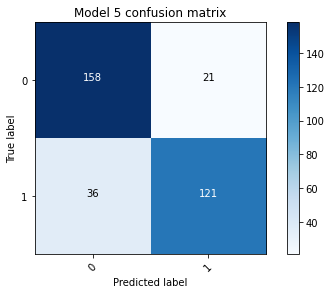

In [ ]:
pred_5_classes = np.rint(pred_5)
confusion_mtx = confusion_matrix(test_labels, pred_5_classes) 
plot_confusion_matrix(confusion_mtx, classes = range(2), normalize=False, title='Model 5 confusion matrix')

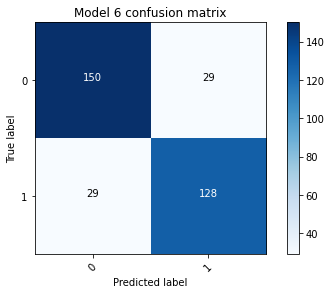

In [ ]:
pred_6_classes = np.rint(pred_6)
confusion_mtx = confusion_matrix(test_labels, pred_6_classes) 
plot_confusion_matrix(confusion_mtx, classes = range(2), normalize=False, title='Model 6 confusion matrix')

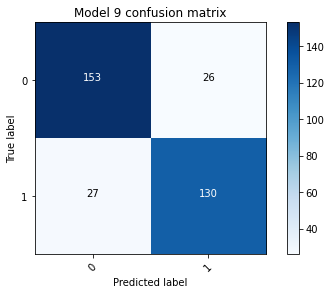

In [ ]:
pred_9_classes = np.rint(pred_9)
confusion_mtx = confusion_matrix(test_labels, pred_9_classes) 
plot_confusion_matrix(confusion_mtx, classes = range(2), normalize=False, title='Model 9 confusion matrix')

In [11]:
def plot_roc(preds, names, titles='ROC curve'):
    plt.figure(figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
    for pred, name in zip(preds, names):
        fpr, tpr, _ = roc_curve(test_labels, pred)
        auc_keras = auc(fpr, tpr)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.plot(fpr, tpr, label=(name +' (area = {:.3f})'.format(auc_keras)))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='lower right')
    plt.show()

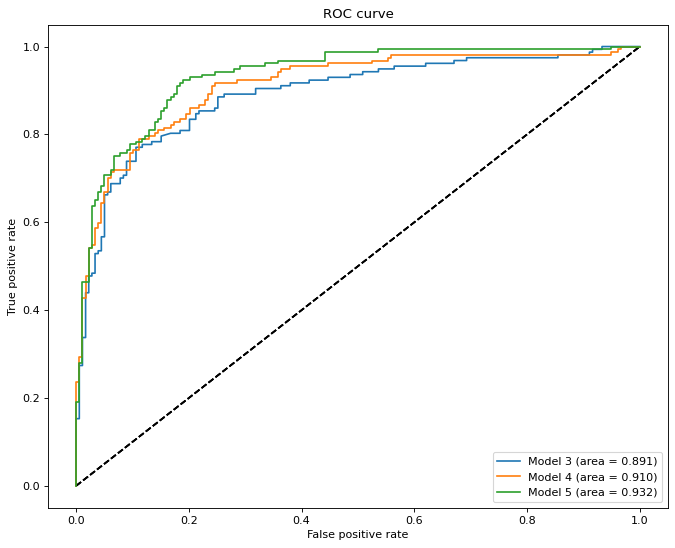

In [12]:
plot_roc([pred_5, pred_6, pred_9], names=['Model 3', 'Model 4', 'Model 5'])